## Vector Quantized Variational AutoEncoder

#### Recap: K Means Algorithm

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/kmeans_clustering.png?raw=true" width="600"/>
</div>

[Image Source](https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c)

The purpose of the K-Means (Unsupervised) algorithm is to cluster data! But how does it do this? Well, K-Means was actually a method derived from Signal Processing to perform **Vector Quantization** and partition n observations in K cluters. Basically, you can say that, instead of storing a large diverse set of samples (each described by a vector), just store a single vector that more or less represents all of them. There are a ton of ways to describe this vector, but in K Means they are known as the cluter centers. Therefore, the algorithm searches for cluster centers that minimize the distance from itself and the points in its cluster, and maximized the distance from itself and points in other clusters. 

Here is the KMeans algorithm at a high level:

1. Randomly initialize K Cluster Centroids
2. Find the closest points to each centroid and store that as the current cluster
3. Take the average of each clusters and set the averages as the new cluster center
4. Repeat 2 and 3 and cluster centers stop changing

This is really import in signal quantization. For example, all signals (before they get digitally saved) are continuous. Speech is continuous waves of pressure, images are continuous intensities of photons, and so on. But once the sound waves hits a microphone or photos hit a camera sensor, they become digitized and quantized, because digital computers can only store discrete numbers not continuous systems. In this Analog to Digital Conversion though, one of the things that determine the quality of the digital signal (and its ability to store the original analog signal) is the Bit-Depth. 

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/bit_depth.jpg?raw=true" width="400"/>
</div>

[Image Source](https://www.lumenera.com/blog/bit-depth)

You can think about Bit-Depth as the number of wells we store data in. For example, if your Bit Depth is 1, then all values less than some intensity will be mapped to one value, and all values higher than that intensity will be mapped to another (your image can only represent two colors then in black and white). As your bit depth increases, your number of wells increase, and number of discrete states we can map a continuous value to increases. As your bit depth goes to infinity, we will have a perfect reconstruction of the continuous signal, but the goal is to have the smallest bit depth possible but have good enough signal reproduction. In the case of K Means, we want to have only as many clusters as there are in our data, any more would be a waste (typically if you have a K larger than the number of clusters, individual clusters will be split into multiple). 


#### What is a Vector Quantized Variational Autoencoder?

Other than being a mouthful, it does a lot of what we just talked about previously! A Variational AutoEncoder maps data to a continuous gaussian distribution. The penalty we pay for this is, we are learning interpolation between classes that don't make sense. If you have a dataset of Cats and Cars, the model will not only learn the data distribution of them, but also try to learn the distribution of Cat-Car hybirds. So instead of mapping to a continious gaussian distiribution, represented by the latent vectors $Z$, we will learn $e_j$ which is the j'th vector in a **codebook** of discrete vectors! Here is a visual of what this looks like:

<div>
<img src="https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/src/visuals/vqvae.png?raw=true" width="800"/>
</div>

[Image Source](https://arxiv.org/pdf/1711.00937.pdf)

So you have an Encoder Neural Network that takes an image and compresses it down to some Latent Vector $Z$. We then compare continuous $Z$ to all our available discrete codevectors $e$ inside our codebook, and pick the codevector that is **closest to our continous vector**. The discrete vector is then passed to our decoder and the original image is reconstructed. But what do I mean by discrete codevectors? Take a look at the embeddings space in the visual above. We have a total of $K$ codevectors $e_1 ... e_k$, and a hyperparameter for our model is $K$, how many codevectors do we want? (Just like in K Means, how many clusters do you want?) The decoder will **only** get one of the **K** codevectors, rather than the infinite possibilities of the continuous vectors $z$.

But do you see a problem with this formulation. We need to find the closet vector between $z$ and $e$, meaning there is now a $min$ operation in our chain of computations. $min$ is a non-differentiable function, therefore this will break backpropagation, so we have to do something to fix this! Let me show you the Loss function for the model and we will break down each piece:

$$L = \log p(x|z_q(x)) + ||sg[z_e(x)] - e||_2^2 + \beta||z_e(x) - sg[e]||_2^2$$

$sg$ stands for stopgradient. As I mentioned before, there is no way to compute the derivative between our codebook and the output of our encoder. We can try to and you will see immediately why:

**Broken Derivative**

We will go through each part of the loss in a bit, but lets quickly take a look at this really important aspect! What I want to try here is to take the derivative of our codevector $e$ w.r.t our encoder output $z$, something we would definitely need during backpropagation to update our codevectors. Lets do this for the second part of the Loss function $||sg[z_e(x)] - e||_2^2$ without the stop gradient

$$\frac{de}{dz}[(z - e_i)^2]$$

We can also let $e_i$ be the the selected vector from our codebook that was closest (mean squared error distance) to our input $z$, so we can write it as:

$$e_i = \mathop{\min}\limits_{i}[(z-e)^2]$$

So lets plug in for our expression and do chain rule!

$$\frac{de}{dz}[(z - \mathop{\min}\limits_{i}[(z-e)^2])^2]$$

$$2*(z - \mathop{\min}\limits_{i}[(z-e)^2])\frac{de}{dz}\mathop{\min}\limits_{i}[(z-e)^2]$$

But how do I enter the $min$ function? What is the derivative of $min$? There isn't any! So the only way to take this derivative is simply by skipping over it. The stop gradient ensures this, and instead of attempting to do a chain rule into our $min$ function, we will just treat the entire value of $min$ as a constant, and ignore any internal gradients that come from it. But if thats the case, how do we update our embeddings $e$ that we can't even reach with gradients?

#### Disecting the Loss Function

Lets go through our loss function piece by piece. The VQ-VAE paper has three losses added together for this to work:

- **Reconstruction Loss**: Just like our regular autoencoder, we need to make sure our output looks like the input, so we have a Mean Squared Error Reconstruction loss
- **Codebook Loss**: Because we cannot compute derivatives between our encoder output $z$ and our quantized latent $e$ due to the $min$ operation, we have to take different approach. What we do know is that $e$ should be somewhat close to $z$, afterall, $e$ is attempting to clump $z$ together into clusters. Therefore, whatever the output of $z$ may be, we need to ensure that $e$ is close to it, or the mean squared error between $e$ and $z$ is small. This will include a stop gradient, and we will treat $z$ like a constant (with no chaining into the operation), and update $e$ such that it minimized the distance between itself and $z$.
- **Commitment Loss**: We actually have to go the other way too. Codebook loss ensures that our quantized embeddings are moving closer to the output of the encoder. But the mean squared error method used in the codebook loss ends up learning the codebook slower than the rest of the parameters in the model in practice. Remember, the encoders job is to create continuous latent vectors that seperate out classes from one another. If we had only two classes, the encoder will theoretically push one towards $\infty$ and the other towards $-\infty$, seperating out the classes as far as possible. The codevectors will then chase after these (as the codebook loss minimizes the difference between codevectors and the output of the encoder) and then also diverge! Therefore, another loss needs to be included, where the output of the encoder $z$ needs to be close to our quantized embeddings $e$! This is exactly the reverse of the codebook loss, and because we want gradients on $z$ we have to hold our $e$ constant, so the stop gradient is applied to $e$ this time. The reason we have this term seperated out is we also include a weight to the commitment loss (set to 0.25 in the paper). This is because it is important to allow the encoder to seperate out the classes, just not too much so we lower the penalty. 


So a recap, we have three componets to the losses:
- Reconstruction Loss: $ \log p(x|z_q(x))$ ensures our output looks like the input and we will use Mean Squared Error
- Codebook Loss: $||sg[z_e(x)] - e||_2^2 $ will update our codevectors in the codebook by moving them closer to the output of the encoder $z$, while not drilling down into the $min$ function by placing a stop gradient on $z$
- Commitment Loss: $\beta||z_e(x) - sg[e]||_2^2$ is exactly the opposite of our codebook loss, but ensures the output of the encoder is close to our codevectors, and has a weight $\beta$ to allow for some divergence.

How do we do a stop gradient though?

```python
import torch

x = torch.tensor([1.], requires_grad=True)
y = 2*x + 3

print(y) # tensor([5.], grad_fn=<AddBackward0>)
print(y.detach()) # tensor([5.])

```

If we **detach** a tensor from the computational graph, it becomes a constant with no memory of the chain of computations before or after it! So this will be our tool in PyTorch to perform this operation. (If you use tensorflow, there is a dedicated *stop_gradient* function given)


#### Hold on a second, Where's the Variational AutoEncoder?

All that work we did in the last section, showing how we can use KL Divergence to map our distribution to a specific gaussian, why is that not included anymore? Lets take a look at our posterior $q(z=k|x)$

\begin{equation}
  q(z=k|x) =
    \begin{cases}
      1 & \text{for $k = \mathop{argmin}\limits_{j}||z_e(x) - e_j||_2^2$}\\
      0 & \text{otherwise}\\
    \end{cases}       
\end{equation}

The authors of the paper say that technically, the posterior distribution is known and deterministic. The vectors are not chosen at random (like when sampling from the posterior distribution in VAE) but selected via the mean squared error metric. In this case, it is fair to say any of the $k$ vectors are equally likely to be chosen and we can assume a **Uniform Prior** over $z$. Therefore we can write our prior as:

$$p(z) = \frac{1}{K}, \text{for all code vectors $k = 1, 2, ... K$}$$

What was our formula for the Loss of VAE from before? We wanted to maximize our Evidence Lower Bound (ELBO):

$$-D_{KL} + Reconstruction$$
$$=-D_{KL}(q_{\theta}(z|x)||p(z)) + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

Lets just take a look at the $D_{KL}$ piece, use the formula for KL Divergence, and substitute in our uniform prior:

$$D_{KL}(q_{\theta}(z|x)||p(z))$$
$$= \sum_{z}q_{\theta}(z|x) \cdot \log \frac{q_{\theta}(z|x)}{p(z)}$$

Remember again $q_{\theta}(z|x)$ is 0 for all codevectors except for the the one that is closest, which we designate as codevector $k$ and whoes posterior has value 1.

$$= q_{\theta}(k|x) \cdot \log \frac{q_{\theta}(k|x)}{p(k)}$$
$$= 1 \cdot \log \frac{1}{\frac{1}{K}}$$
$$= \log K$$

Therefore, with this fair assumption of a uniform prior over our quantized latents, the entire KL divergence term is constant. We have no need to include it in our loss calculation, as mimimizing a function, or mimimizing the same function plus a constant gives the same minimum. 

### Last Part: How Do we Pass Gradients from Decoder to Encoder

We now have a way to update our embeddings and make sure our training doesn't diverge. But we still need to perform backpropagation through this whole system. The proposed solution from the paper was to use a straight through estimator, where we will copy the gradients from the input of the decoder to the output of the encoder. The implementation of this is a little weird in PyTorch but hopefully this will make sense! Lets pretend you have something called *z* that that is the latents from our encoder, and then you have *codes* that are the quantized verion of z. The codes are then passed to the decoder for reconstruction. During backpropagation, we have to find the following derivatives (with super forced notation but should give some insight). 

- Derivative of the Decoder w.r.t *codes* (this is totally possible as this is just a regular neural network)
- Derivative of the *codes* w.r.t *z* (this is not allowed, there is a min operation in there which will break the gradient)
- Derivative of *z* w.r.t the Encoder (again totally allowed as this is a regular neural network)

So the problem, we need to go from *codes* back to *z* without actually going through that computational graph in between, and so we will use the *straight-through* estimator. Just copy all the gradients from *codes* back to *z*, so we bypass all non-differentiability between them. This was probably the weirdest part of learning about this architecture for me so lets do it in a little detail!

We will create a module that will take a tensor, apply an "encoder" linear layer, quantize it to some embeddings, and then apply a "decoder" linear layer for our output. 

Encoder Gradient: None


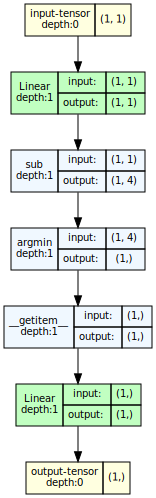

In [17]:
import torch
import torch.nn as nn

# May not have torchview so install if needed, check https://github.com/mert-kurttutan/torchview?tab=readme-ov-file for instructions if stuck!
# !pip install -q -U graphviz
# !pip install -q torchview

from torchview import draw_graph

class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1,1)
        self.embeddings = nn.Parameter(torch.tensor([-10.,0.,4.,3.]), requires_grad=True)
        self.dec = nn.Linear(1,1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z-self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        d = self.dec(e_j)
        return d

q = Quantize()
x = torch.ones(1).reshape(-1,1)
out = q(x)
out.backward()
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

We can see above, that the gradient didn't make it back to z, which is a problem because then gradients arent making it to our encoder in that case. To copy gradients we will do it a unique way that was new to me:

```python
e_j = z + (e_j - z).detach()
```

This looks like we are just doing $e_j = e_j$ but remember, z is the input to our decoder so by setting $e_j = z$ first, we are copying those gradients over. But we dont want any gradients to occur between $e_j$ and $z$ (where the dreaded $min$ operation is), so we will add the constants $e_j$ and $-z$ (they were detached) so all we are left with as far as the computational graph is concerned is the identity $e_j = e_j$. It a pretty nifty trick for gradient copying without having to write custom PyTorch functions and specifying a *.backward()* method! We can give it a try to see if it works!:

Encoder Gradient: tensor([[-0.7442]])


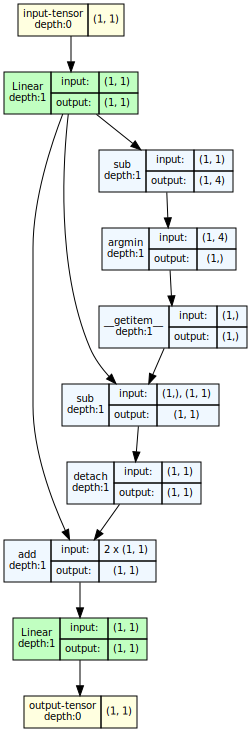

In [18]:
class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1,1)
        self.embeddings = nn.Parameter(torch.tensor([-10.,0.,4.,3.]), requires_grad=True)
        self.dec = nn.Linear(1,1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z-self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        e_j = z + (e_j - z).detach()
        d = self.dec(e_j)
        return d
        
q = Quantize()
x = torch.ones(1).reshape(-1,1)
out = q(x)
out.backward()
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

### Lets Build our VQVAE!

We finally have all the pieces we need to build our VQVAE so we can start!

In [19]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from IPython.display import HTML
from sklearn.manifold import TSNE

### Load in the Vanilla AE, VAE and Plotting Functions from Previous Tutorials ###
from models import LinearVanillaAutoEncoder, LinearVariationalAutoEncoder, \
                    ConvolutionalAutoEncoder, ConvolutionalVartiationalAutoEncoder
from utils import build_embedding_animation, interpolate_space, VAELoss

### Stuff to Visualize the Latent Space ###
from celluloid import Camera
from IPython.display import HTML

### Seed Everything ###
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)


### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)
train_set = MNIST("../../data/mnist/", train=True, transform=tensor_transforms)
test_set = MNIST("../../data/mnist/", train=False, transform=tensor_transforms)


### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"


### Vector Quantizer

The first step is a vector quantizer. The expected input to this will be Batch x Latent Dim. Now this will happen in two ways depending on the architecture:

- Our Linear Neural Network's encoder will output a Batch x Latent so we are good to go here
- Our Convolutional Neural Network encoder will output Batch x Latent_channels x Height x Width. We will have to do some manipulation to quantize every pixel across the channels for all the images in the batch
    - [B,L,H,W] => [B,H,W,L] => [B\*H\*W,L]
 
**Computing Distances**

There are two ways we can compute distances, so follow the shapes of the tensors, but here is the high level idea, our goal is to compute the mean squared distance between our input $x$ and **ALL** codevectors $e$, so $(x-e)^2$. In the naive method, we will have to do matrix inflation to get all our shapes to line up, but this is costly. The better way is to rewrite $(x-e)^2$ as $x^2 - 2xe + e^2$ and just do a couple matrix multiplications to get the same output! Both implementations are below so you can compare quickly.  

**Finding the Closest Vector**
Now that we have the distances, we can use *argmin* to find the index of the closest vector and grab those vectors via matrix multiplication. Lets say we have the following embedding vectors:


$$E = \left[\begin{matrix} a & b & c \\ d & e & f \\ g & h & i \end{matrix}\right]$$

Lets also say we pass in two samples and the first sample is closest to the first embedding vector and second sample is closest to the third embedding vector. We can then create a matrix like this, indicating for every batch, which matrix we want:

$$i = \left[\begin{matrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{matrix}\right]$$

Then multiplying $i$ by $E$, we can get:

$$i \cdot E = \left[\begin{matrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{matrix}\right] \cdot \left[\begin{matrix} a & b & c \\ d & e & f \\ g & h & i \end{matrix}\right] = \left[\begin{matrix} a & b & c \\ g & h & i \end{matrix}\right]$$

Which grabs the corresponding embedding vectors! The only reason we did it this way is because we can basically "index" out giant embedding matrix with a simple matrix multiplication rather than for loops or annoying indexing. Im sure there are other ways to do this like [scatter](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_) but I want to keep this as simple as possible!

In [20]:
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()
        
        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x, efficient=True):

        batch_size = x.shape[0]
        
        ### Bad Implementation That Requires Matrix Expansion ###
        if not efficient:

            # C: Codebook Size, L: Latent Dim
            
            ### Embedding: [C, L] -> [B, C, L]
            emb = self.embedding.weight.unsqueeze(0).repeat(batch_size,1,1)

            ### X: [B, L] -> [B, 1, L]
            x = x.unsqueeze(1)

            ### [B, C]
            distances = torch.sum(((x - emb)**2), dim=-1)

        ### Alternative more Efficient Implementation ###
        else:
            ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

            ### L2: [B, L] -> [B, 1]
            L2 = torch.sum(x**2, dim=1, keepdim=True)

            ### C2: [C, L] -> [C]
            C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

            ### CL: [B,L]@[L,C] -> [B, C]
            CL = x@self.embedding.weight.t()

            ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
            distances = L2 - 2*CL + C2
        
        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(batch_size, self.codebook_size, device=x.device)

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx,closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents 


vq = VectorQuantizer(codebook_size=4,latent_dim=2)
rand = torch.randn(2,2)
vq(rand)

tensor([[-0.0515,  0.1871],
        [-0.1695, -0.1089]], grad_fn=<MmBackward0>)

### Write the Linear VQVAE

Now that we have our quantizer ready, we can actually build our model! Again, I copied the original Linear AutoEncoder from the [Intro to AutoEncoder](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Generation/AutoEncoder%20Basics) tutorial so you can see the changes needed to make it a Vector Quantized Linear AutoEncoder. 

Basically everything will stay the same, but we need to compute the commitment and codebook losses just so we have them for loss calculation later! Again, we can't forget the stop gradients implemented as *.detach()*!

In [21]:
class LinearVectorQuantizedVAE(nn.Module):
    def __init__(self, latent_dim=2, codebook_size=512):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        #########################################################
        ###  The New Layers Added in from Original VAE Model  ###
        self.vq = VectorQuantizer(codebook_size, latent_dim)
        
        #########################################################
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid()
        )


    def forward_enc(self, x):

        x = self.encoder(x)
    
        return x

    def quantize(self, z):
        
        #############################################
        ## Quantize the Latent Space Representation #

        codes = self.vq(z)

        ### Compute VQ Loss ###
        codebook_loss = torch.mean((codes - z.detach())**2)
        commitment_loss = torch.mean((codes.detach() - z)**2)

        ### Straight Through ###
        codes = z + (codes - z).detach()
        
        #############################################

        return codes, codebook_loss, commitment_loss

    def forward_dec(self, x):
        codes, codebook_loss, commitment_loss = self.quantize(x)
        decoded = self.decoder(codes)
        
        return codes, decoded, codebook_loss, commitment_loss
        
    def forward(self, x):
        
        batch, channels, height, width = x.shape
        
        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        latents = self.forward_enc(x)
        
        ### Pass Sampled Data Through Decoder ###
        quantized_latents, decoded, codebook_loss, commitment_loss = self.forward_dec(latents)

        ### Put Decoded Image Back to Original Shape ###
        decoded = decoded.reshape(batch, channels, height, width)

        return latents, quantized_latents, decoded, codebook_loss, commitment_loss

m = LinearVectorQuantizedVAE()
rand = torch.randn(4,1,32,32)
latents, quantized_latents, decoded, codebook_loss, commitment_loss = m(rand)

### Update Training Loop

This training loop is almost identical to our [Variational AutoEncoders](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Generation/AutoEncoder%20Basics) tutorial, I have just added in a few things to support the VQVAE. The main differences are:
- The VQVAE returns more stuff, so we have to create a new **model_type**
- I want to store both the Latent output $z$ and the Quantized output $e$ so we can see what they both look like! 

In [22]:
def train(model,
          kl_weight,
          train_set,
          test_set,
          batch_size, 
          training_iterations, 
          evaluation_iterations,
          model_type="VQVAE"):

    if model_type != "VAE": kl_weight = None
        
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    
    encoded_data_per_eval = []
    quantized_encoded_data_per_eval = [] if model_type == "VQVAE" else None
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))
    
    train = True
    
    step_counter = 0
    while train:

        for images, labels in trainloader:
            
            images = images.to(device)

            if model_type == "VQVAE":
                encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
                reconstruction_loss = torch.mean((images-decoded)**2)
                loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
            elif model_type == "VAE":
                encoded, decoded, mu, logvar = model(images)
                loss = VAELoss(images, decoded, mu, logvar, kl_weight)
            elif model_type == "AE": 
                encoded, decoded = model(images)
                loss = torch.mean((images-decoded)**2)
                
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:
                
                model.eval()
                
                encoded_evaluations = []
                if model_type == "VQVAE":
                    quantized_encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)
            
                    if model_type == "VQVAE":
                        encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
                        reconstruction_loss = torch.mean((images-decoded)**2)
                        loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
                    elif model_type == "VAE":
                        encoded, decoded, mu, logvar = model(images)
                        loss = VAELoss(images, decoded, mu, logvar, kl_weight)
                    elif model_type == "AE": 
                        encoded, decoded = model(images)
                        loss = torch.mean((images-decoded)**2)
                        
                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu(), labels.reshape(-1,1)
                    
                    encoded_evaluations.append(torch.cat((encoded.flatten(1), labels), axis=-1))

                    if model_type == "VQVAE":
                        quantized_encoded = quantized_encoded.cpu()
                        quantized_encoded_evaluations.append(torch.cat((quantized_encoded.flatten(1), labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())
                if model_type == "VQVAE":
                    quantized_encoded_data_per_eval.append(torch.concatenate(quantized_encoded_evaluations).detach())
                
                                                       
                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)
                
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)
           
            
            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    if model_type == "VQVAE":
        quantized_encoded_data_per_eval = [np.array(i) for i in quantized_encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])
    
    return model, train_losses, evaluation_losses, encoded_data_per_eval, quantized_encoded_data_per_eval




### Lets Train!!

In [23]:
### Lets Train All of our Linear Models!!! ###

linear_ae = LinearVanillaAutoEncoder()
linear_ae, train_losses, evaluation_losses, linear_ae_encoded_data_per_eval, _ = train(linear_ae,
                                                                                       kl_weight=None,
                                                                                       train_set=train_set,
                                                                                       test_set=test_set,
                                                                                       batch_size=64,
                                                                                       training_iterations=25000,
                                                                                       evaluation_iterations=250,
                                                                                       model_type="AE")
linear_vae = LinearVariationalAutoEncoder()
linear_vae, train_losses, evaluation_losses, linear_vae_encoded_data_per_eval, _ = train(linear_vae,
                                                                                         kl_weight=0.0005,
                                                                                         train_set=train_set,
                                                                                         test_set=test_set,
                                                                                         batch_size=64,
                                                                                         training_iterations=25000,
                                                                                         evaluation_iterations=250,
                                                                                         model_type="VAE")

linear_vqvae = LinearVectorQuantizedVAE()
(linear_vqvae, train_losses, 
 evaluation_losses, linear_vqvae_encoded_data_per_eval, 
 linear_vqvae_quantized_encoded_data_per_eval) = train(linear_vqvae,
                                                       kl_weight=None,
                                                       train_set=train_set,
                                                       test_set=test_set,
                                                       batch_size=64,
                                                       training_iterations=25000,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.02920756734162569
Final Evaluation Loss 0.029510183686948126


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.03150284688919783
Final Evaluation Loss 0.031693256632157954


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.03292331495136023
Final Evaluation Loss 0.03279968311974577


### Lets Compare Encoder Latents to Quantized Latents

Lets see what our quantization is actually doing! We can compare the embeddings space of the direct output of our encoder to that after the quantization has occured. 

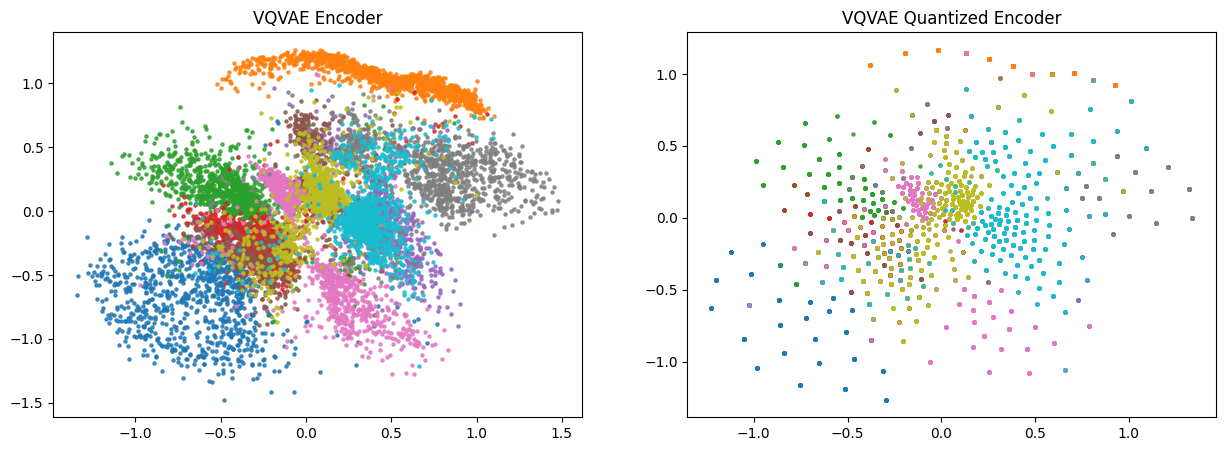

In [24]:
### Grab Encodings ###
encoded_latent = linear_vqvae_encoded_data_per_eval[-1]
quantized_encoded_latent = linear_vqvae_quantized_encoded_data_per_eval[-1] 

fig, ax = plt.subplots(1,2, figsize=(15,5))

### Plot Continuous Encoded ###
encoded_latent = pd.DataFrame(encoded_latent, columns=["x", "y", "class"])
encoded_latent = encoded_latent.sort_values(by="class")
encoded_latent["class"] = encoded_latent["class"].astype(int).astype(str)
for grouper, group in encoded_latent.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[0].set_title("VQVAE Encoder")

### Plot Quantized ###
quantized_encoded_latent = pd.DataFrame(quantized_encoded_latent, columns=["x", "y", "class"])
quantized_encoded_latent = quantized_encoded_latent.sort_values(by="class")
quantized_encoded_latent["class"] = quantized_encoded_latent["class"].astype(int).astype(str)
for grouper, group in quantized_encoded_latent.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[1].set_title("VQVAE Quantized Encoder")
plt.show()


### Lets Compare AE to VAE to VQVAE

First lets take a look at the latent space for all of these models. For the VQVAE we will look at the Encoder outputs, to compare instead of the quantized ones

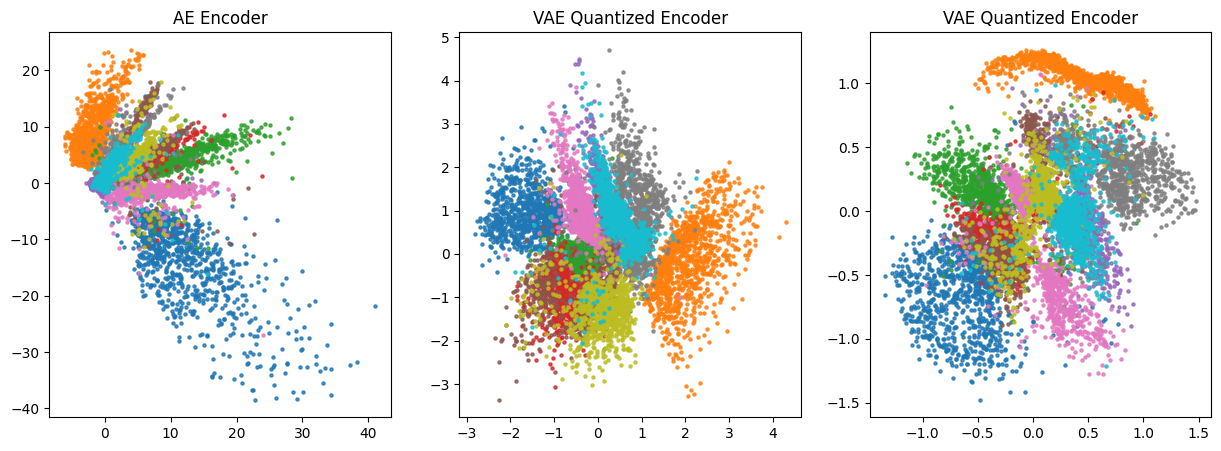

In [26]:
### Grab Encodings ###
ae_encoded_latent = linear_ae_encoded_data_per_eval[-1]
vae_encoded_latent = linear_vae_encoded_data_per_eval[-1]
vqvae_encoded_latent = linear_vqvae_encoded_data_per_eval[-1]

fig, ax = plt.subplots(1,3, figsize=(15,5))

ae_encoded_latent = pd.DataFrame(ae_encoded_latent, columns=["x", "y", "class"])
ae_encoded_latent = ae_encoded_latent.sort_values(by="class")
ae_encoded_latent["class"] = ae_encoded_latent["class"].astype(int).astype(str)
for grouper, group in ae_encoded_latent.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[0].set_title("AE Encoder")

vae_encoded_latent = pd.DataFrame(vae_encoded_latent, columns=["x", "y", "class"])
vae_encoded_latent = vae_encoded_latent.sort_values(by="class")
vae_encoded_latent["class"] = vae_encoded_latent["class"].astype(int).astype(str)
for grouper, group in vae_encoded_latent.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[1].set_title("VAE Quantized Encoder")

vqvae_encoded_latent = pd.DataFrame(vqvae_encoded_latent, columns=["x", "y", "class"])
vqvae_encoded_latent = vqvae_encoded_latent.sort_values(by="class")
vqvae_encoded_latent["class"] = vqvae_encoded_latent["class"].astype(int).astype(str)
for grouper, group in vqvae_encoded_latent.groupby("class"):
    ax[2].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[2].set_title("VAE Quantized Encoder")
plt.show()


### Reconstruction Comparison of Architectures

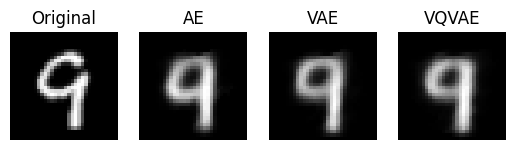

In [27]:
generated_index = 150
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

_, ae_reconstructed = linear_ae(image)
_, vae_reconstructed, *_ = linear_vae(image)
_,_,vqvae_reconstructed, *_ = linear_vqvae(image)

image = image.to("cpu")
ae_reconstructed = ae_reconstructed.to("cpu").detach().numpy()
vae_reconstructed = vae_reconstructed.to("cpu").detach().numpy()
vqvae_reconstructed = vqvae_reconstructed.to("cpu").detach().numpy()

fig, ax = plt.subplots(1,4)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(ae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("AE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

ax[2].imshow(vae_reconstructed.squeeze(), cmap="gray")
ax[2].set_title("VAE")
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].axis("off")

ax[3].imshow(vqvae_reconstructed.squeeze(), cmap="gray")
ax[3].set_title("VQVAE")
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].axis("off")


plt.show()

You cant see too much of a difference here because the dataset is super simple, but it is subtly clear that the VQVAE is pretty close to the AE in quality, where the VAE is slightly more blurry! Lets interpolate the space and see what the data looks like!

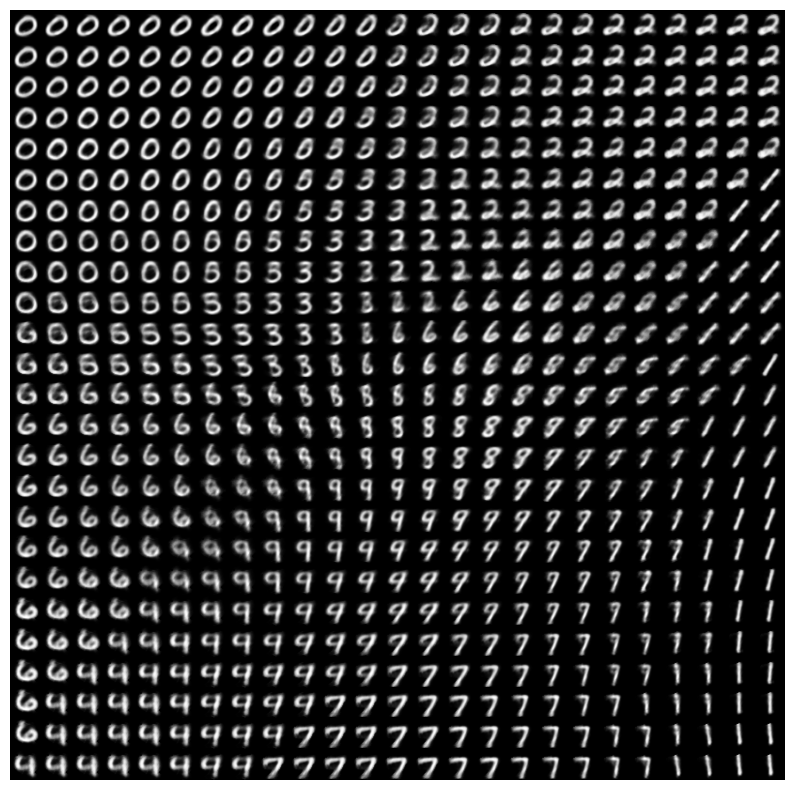

In [28]:
def interpolate_space(model, x_range=(-1,1), y_range=(-1,1), num_steps=25):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    x_space = np.linspace(x_range[0], x_range[1], num_steps)
    y_space = np.linspace(y_range[0], y_range[1], num_steps)

    points = []
    for x in x_space:
        for y in y_space:
            points.append([x,y])

    points = torch.tensor(points, dtype=torch.float32).to(device)

    ### Pass Through Model Decoder and Reshape ###
    dec = model.forward_dec(points)[1].detach().cpu()
    dec = dec.reshape(-1, 1, 32, 32)
    dec = dec.reshape((num_steps,num_steps, *dec.shape[1:]))

    fig, ax = plt.subplots(num_steps,num_steps, figsize=(10,10))

    for x in range(num_steps):
        for y in range(num_steps):
            
            img = np.array(dec[x,y].permute(1,2,0))
            ax[x,y].imshow(img, cmap="gray")
            ax[x,y].set_xticklabels([])
            ax[x,y].set_yticklabels([])
            ax[x,y].axis("off")
            
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interpolate_space(linear_vqvae)

### Theres a problem...

If you take a close look at the latents, do you see that a lot of the generations are repeated? We no longer have variety in our generation... This is because we have mapped every encoding from our encoder neural network to a single Embedding vector. Again remember, the output of our encoder was a Batch Size x Latent Dim, and each latent dim was mapped to the single quantized embedding. What if we have multiple embedding vectors per image?

For example, the output of our convolutional encoder we will make in a bit is Batch x Latent Channel x Height x Width. Ignoring the batch size for now, we can reshape this image to Height*Width x Latent, and then each latent vector for every pixel in our image will get a quantized representation. 

That means if our image was mapped to a 4 Latent Dim x 4 Height x 4 Width, this will be mapped to a 16 pixels x 4 latent dim, so all 16 pixels will be independently mapped to a latent dimension. If we have 512 unique codevectors in our image, then we will have a total of **512*16** possible combinations of latents to generate from! 

### Convolutional Vector Quantized Variational AutoEncoder

We will again start from our original Convolutional Autoencoder implementation and make the necessary changes!

In [29]:
class ConvolutionalVectorQuantizedVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=4, codebook_size=512):
        super().__init__()

        self.bottleneck = latent_dim
        self.in_channels = in_channels 
        self.codebook_size = codebook_size
        
        self.encoder_conv = nn.Sequential(

            ### Convolutional Encoding ###
            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(8),
            nn.ReLU(), 

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(in_channels=16, out_channels=self.bottleneck, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(self.bottleneck),
            nn.ReLU(),

            
        )

        #########################################################
        ###  The New Layers Added in from Original VAE Model  ###
        self.vq = VectorQuantizer(codebook_size, latent_dim)
        
        #########################################################

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.bottleneck, out_channels=16, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=in_channels, kernel_size=2, stride=2, padding=1),
            nn.Sigmoid()
        )
    

    def forward_enc(self, x):
        batch_size, num_channels, height, width = x.shape
        conv_enc = self.encoder_conv(x)
        return conv_enc

    def quantize(self, z):
        
        #############################################
        ## Quantize the Latent Space Representation #

        codes = self.vq(z)

        ### Compute VQ Loss ###
        codebook_loss = torch.mean((codes - z.detach())**2)
        commitment_loss = torch.mean((codes.detach() - z)**2)

        ### Straight Through ###
        codes = z + (codes - z).detach()
        
        #############################################

        return codes, codebook_loss, commitment_loss

    def forward_dec(self, x):
        batch_size, channels, height, width = x.shape

        ##########################################
        ### Reshape B x C x H X W -> B*H*W x C ###
        x = x.permute(0,2,3,1)
        x = torch.flatten(x, start_dim=0, end_dim=-2)

        ### Quantize Data ###
        codes, codebook_loss, commitment_loss = self.quantize(x)

        ### Reshape Back to B x C x H X W ###
        codes = codes.reshape(batch_size, height, width, channels)
        codes = codes.permute(0,3,1,2)

        ##########################################
        
        conv_dec = self.decoder_conv(codes)
        
        return codes, conv_dec, codebook_loss, commitment_loss
        
    def forward(self, x):
        batch_size, num_channels, height, width = x.shape
        latents = self.forward_enc(x)
        quantized_latents, decoded, codebook_loss, commitment_loss = self.forward_dec(latents)
        return latents, quantized_latents, decoded, codebook_loss, commitment_loss

rand = torch.randn(2,1,32,32)
m = ConvolutionalVectorQuantizedVAE()
latents, quantized_latents, decoded, codebook_loss, commitment_loss = m(rand)

### Lets Train!

In [30]:
conv_ae = ConvolutionalAutoEncoder()
conv_ae, train_losses, evaluation_losses, conv_ae_encoded_data_per_eval, _ = train(conv_ae,
                                                                                       kl_weight=None,
                                                                                       train_set=train_set,
                                                                                       test_set=test_set,
                                                                                       batch_size=64,
                                                                                       training_iterations=25000,
                                                                                       evaluation_iterations=250,
                                                                                       model_type="AE")
conv_vae = ConvolutionalVartiationalAutoEncoder()
conv_vae, train_losses, evaluation_losses, conv_vae_encoded_data_per_eval, _ = train(conv_vae,
                                                                                         kl_weight=0.0005,
                                                                                         train_set=train_set,
                                                                                         test_set=test_set,
                                                                                         batch_size=64,
                                                                                         training_iterations=25000,
                                                                                         evaluation_iterations=250,
                                                                                         model_type="VAE")

conv_vqvae = ConvolutionalVectorQuantizedVAE()
(conv_vqvae, train_losses, 
 evaluation_losses, conv_vqvae_encoded_data_per_eval, 
 conv_vqvae_quantized_encoded_data_per_eval) = train(conv_vqvae,
                                                       kl_weight=None,
                                                       train_set=train_set,
                                                       test_set=test_set,
                                                       batch_size=64,
                                                       training_iterations=25000,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.0044613742558285594
Final Evaluation Loss 0.004214715019793837


  0%|          | 0/25000 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x722b553c0860>
Traceback (most recent call last):
  File "/home/priyam/anaconda3/envs/torch/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 2035674, 2035722, 2035770) exited unexpectedly

### Lets Plot the Embeddings!! 

In [ ]:
### TSNE Compression of ConvAE ###
conv_ae_encoding = conv_ae_encoded_data_per_eval[-1]
conv_ae_features, conv_ae_labels = conv_ae_encoding[:,:-1], conv_ae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_ae_compressed = tsne.fit_transform(X=conv_ae_features)

conv_ae_encoding = np.hstack((conv_ae_compressed, conv_ae_labels))
conv_ae_encoding = pd.DataFrame(conv_ae_encoding, columns=["x", "y", "class"])
conv_ae_encoding = conv_ae_encoding.sort_values(by="class")
conv_ae_encoding["class"] = conv_ae_encoding["class"].astype(int).astype(str)

### TSNE Compression of ConvVAE ###
conv_vae_encoding = conv_vae_encoded_data_per_eval[-1]
conv_vae_features, conv_vae_labels = conv_vae_encoding[:,:-1], conv_vae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_vae_compressed = tsne.fit_transform(X=conv_vae_features)

conv_vae_encoding = np.hstack((conv_vae_compressed, conv_vae_labels))
conv_vae_encoding = pd.DataFrame(conv_vae_encoding, columns=["x", "y", "class"])
conv_vae_encoding = conv_vae_encoding.sort_values(by="class")
conv_vae_encoding["class"] = conv_vae_encoding["class"].astype(int).astype(str)

### TSNE Compression of ConvVQVAE ###
conv_vqvae_encoding = conv_vqvae_encoded_data_per_eval[-1]
conv_vqvae_features, conv_vqvae_labels = conv_vqvae_encoding[:,:-1], conv_vqvae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_vqvae_compressed = tsne.fit_transform(X=conv_vqvae_features)

conv_vqvae_encoding = np.hstack((conv_vqvae_compressed, conv_vqvae_labels))
conv_vqvae_encoding = pd.DataFrame(conv_vqvae_encoding, columns=["x", "y", "class"])
conv_vqvae_encoding = conv_vqvae_encoding.sort_values(by="class")
conv_vqvae_encoding["class"] = conv_vqvae_encoding["class"].astype(int).astype(str)

### Plot Compression! ###
fig, ax = plt.subplots(1,3,figsize=(15,5))

for grouper, group in conv_ae_encoding.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

for grouper, group in conv_vae_encoding.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

for grouper, group in conv_vqvae_encoding.groupby("class"):
    ax[2].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

ax[0].set_title("Convolutional Autoencoder")
ax[1].set_title("Convolutional Variational Autoencoder")
ax[2].set_title("Convolutional Vector Quantized VAE")

plt.show()

As you can see, not too much of a difference here, although we know this is a super simple dataset so it is expected. What about reconstruction?

### Convolutional Reconstruction Comparison

In [ ]:
generated_index = 500
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

_, conv_ae_reconstructed = conv_ae(image)
_, conv_vae_reconstructed, *_ = conv_vae(image)
_, _,  conv_vqvae_reconstructed, *_ = conv_vqvae(image)


image = image.to("cpu")
conv_ae_reconstructed = conv_ae_reconstructed.to("cpu").detach().numpy()
conv_vae_reconstructed = conv_vae_reconstructed.to("cpu").detach().numpy()
conv_vqvae_reconstructed = conv_vqvae_reconstructed.to("cpu").detach().numpy()

fig, ax = plt.subplots(1,4)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(conv_ae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("AE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

ax[2].imshow(conv_vae_reconstructed.squeeze(), cmap="gray")
ax[2].set_title("VAE")
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].axis("off")

ax[3].imshow(conv_vqvae_reconstructed.squeeze(), cmap="gray")
ax[3].set_title("VQVAE")
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].axis("off")



plt.show()

Again, not a huge difference! Thats alright, we will see more benefits on a larger dataset soon!

### End to AutoEncoder Introduction

That was quite a journey through some of the rigorous mathematics and implementation of all types of AutoEncoders. There is still more to do so here is the order in which I will plan to make the implementations:

- Train larger AE, VAE, and VQVAE architectures on the CelebA dataset
- Implement differentiable quantization through Gumbel-Softmax trick
- VAE and VQVAE for Speech Encodings